<div style="font-size:30pt; font-weight:700;margin-top:50px;margin-bottom:50px;color:royalblue; text-align:center;width:800px;line-height:20pt">Kaggle New York City Taxi Fare Prediction</div>

This workbook is the New York City Taxi Fare Prediction dataset analysis to predict the fare of a taxi trip in New York City.

It is a Kaggle competition available <a href="https://www.kaggle.com/c/new-york-city-taxi-fare-prediction" target="_blank">HERE</a>.

<i><blockquote><b>The Challenge</b></blockquote></i>
    
<blockquote>In this playground competition, hosted in partnership with Google Cloud and Coursera, you are tasked with predicting the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations. While you can get a basic estimate based on just the distance between the two points, this will result in an RMSE of $5-$8, depending on the model used (see the starter code for an example of this approach in Kernels). Your challenge is to do better than this using Machine Learning techniques!

To learn how to handle large datasets with ease and solve this problem using TensorFlow, consider taking the Machine Learning with TensorFlow on Google Cloud Platform specialization on Coursera -- the taxi fare problem is one of several real-world problems that are used as case studies in the series of courses. To make this easier, head to Coursera.org/NEXTextended to claim this specialization for free for the first month!</blockquote>
<figcaption>Kaggle</figcaption>

# 1. Import

In [1]:
#
from scipy import stats
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight');
plt.rcParams['font.size'] = 14;
plt.figure(figsize=(12,5));
palette = sns.color_palette('Paired', 10);

# map
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

# Sci-kit learn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn import set_config; set_config(display='diagram')

<Figure size 864x360 with 0 Axes>

In [2]:
url = 's3://wagon-public-datasets/taxi-fare-train.csv'
data = pd.read_csv(url, nrows=100000)
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


# 2. Dropping useless features

In [3]:
data = data.drop(["key"], axis=1)

# 3. Duplicates

In [4]:
size_before = len(data)
data = data.drop_duplicates()
size_after = len(data)
print(str(size_before - size_after) + " duplicates were removed.")

0 duplicates were removed.


# 4. Missing
<div style="font-weight:700">Droping features that have too many missing values</div>

In [5]:
100 * data.isnull().sum().sort_values(ascending=False)/len(data)

passenger_count      0.0
dropoff_latitude     0.0
dropoff_longitude    0.0
pickup_latitude      0.0
pickup_longitude     0.0
pickup_datetime      0.0
fare_amount          0.0
dtype: float64

<div style="font-weight:700">Seems there is nothing to drop.</div>

# 5. Explore Data

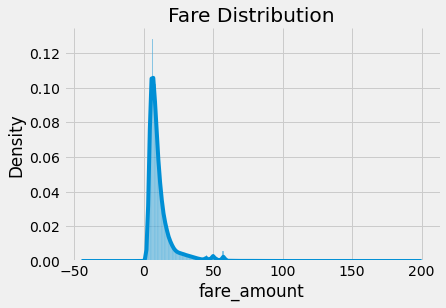

In [6]:
def plot_dist(series=data["fare_amount"], title="Fare Distribution"):
    sns.histplot(series, kde=True, stat='density', discrete=True)
    sns.despine()
    plt.title(title);
    plt.show()
plot_dist()

<div style="font-weight:700">Let's drop absurd values.</div>

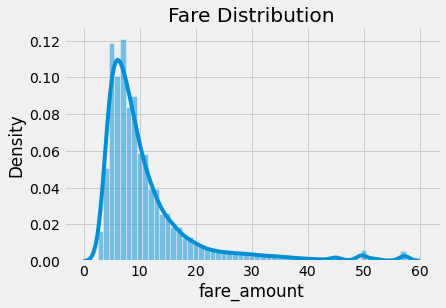

In [7]:
data = data[data.fare_amount.between(0, 60)]
plot_dist(data.fare_amount)

<div style="font-weight:700">We can also visualise binned fare_amount variable:</div>

In [8]:
data['fare-bin'] = pd.cut(data['fare_amount'], bins = list(range(0, 50, 5)), include_lowest=True).astype('str')

# Uppermost bin
data['fare-bin'] = data['fare-bin'].replace(np.nan, '[45+]')

# apply this to clean up the first bin's label
data['fare-bin'] = data['fare-bin'].apply(lambda x: x.replace('-0.001', '0'))

# sort by fare the correct look in the chart
data = data.sort_values(by='fare_amount')

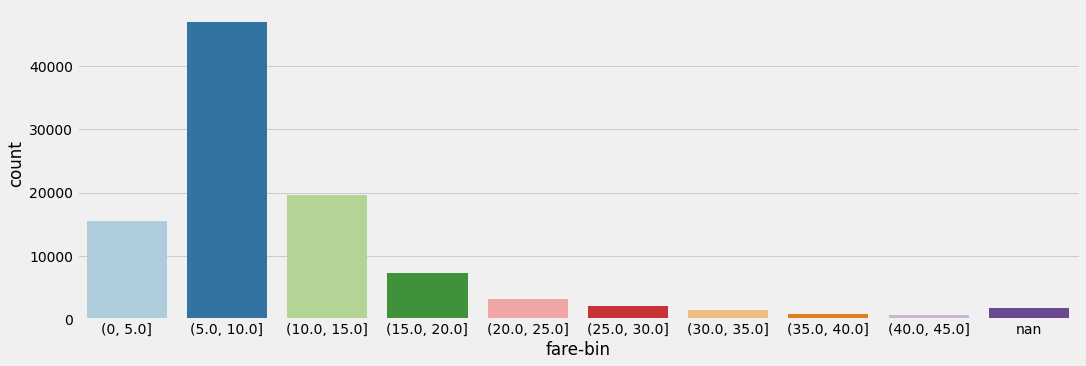

In [9]:
sns.catplot(x="fare-bin", kind="count", palette=palette, data=data, height=5, aspect=3);
sns.despine()
plt.show()

<div style="font-weight:700">Let's have a closer look at <i style="color:royalblue">passenger_count</i> feature</div>

In [10]:
data.passenger_count.describe()

count    99742.000000
mean         1.673758
std          1.300207
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          6.000000
Name: passenger_count, dtype: float64

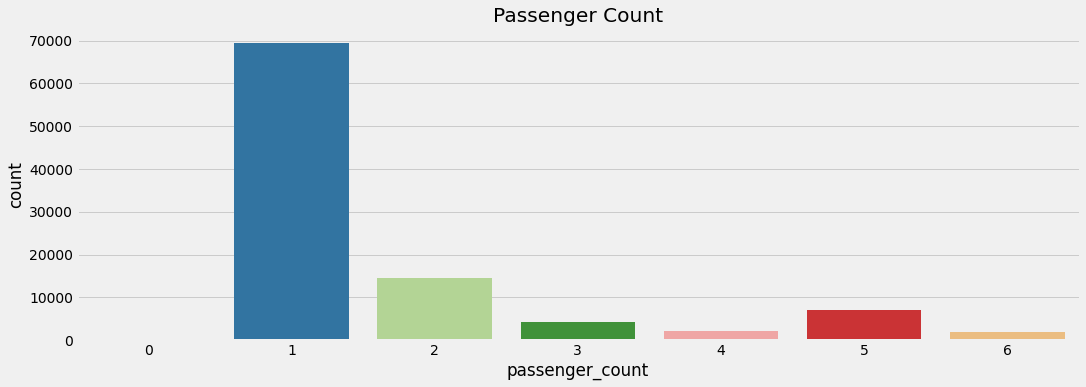

In [11]:
sns.catplot(x="passenger_count", kind="count", palette=palette, data=data, height=5, aspect=3);
sns.despine()
plt.title('Passenger Count');
plt.show()

<div style="font-weight:700">Let's have a look at <i style="color:royalblue">pickup_datetime</i> feature</div>

In [12]:
def extract_time_features(df):
    timezone_name = 'America/New_York'
    time_column = "pickup_datetime"
    df.index = pd.to_datetime(df[time_column])
    df.index = df.index.tz_convert(timezone_name)
    df["dow"] = df.index.weekday
    df["hour"] = df.index.hour
    df["month"] = df.index.month
    df["year"] = df.index.year
    return df.reset_index(drop=True)

In [13]:
data = extract_time_features(data.drop(["fare-bin"], axis=1))
data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dow,hour,month,year
0,0.00,2010-02-15 14:26:01 UTC,-73.987115,40.738808,-74.005911,40.713960,1,0,9,2,2010
1,0.00,2015-05-15 21:40:28 UTC,-74.077927,40.805714,-74.077919,40.805721,1,4,17,5,2015
2,0.00,2010-03-18 19:13:39 UTC,-73.942346,40.806269,-73.942463,40.806129,1,3,15,3,2010
3,0.01,2015-05-01 15:38:41 UTC,-73.939041,40.713963,-73.941673,40.713997,1,4,11,5,2015
4,0.01,2015-02-19 06:18:50 UTC,-73.980331,40.770535,-73.981911,40.771503,1,3,1,2,2015


<div style="font-weight:700">Taxi trip repartition by hour of the day</div>

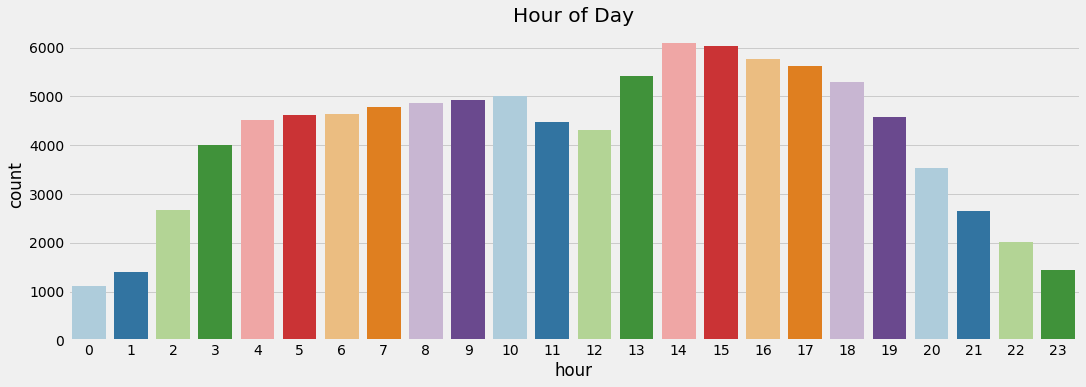

In [14]:
sns.catplot(x="hour", kind="count", palette=palette, data=data, height=5, aspect=3);
sns.despine()
plt.title('Hour of Day');
plt.show()

<div style="font-weight:700">Taxi trip repartition by day of week</div>

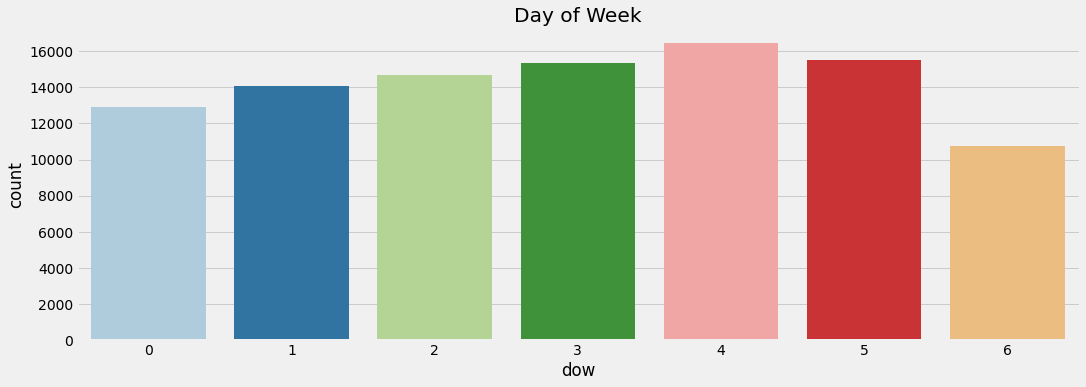

In [15]:
sns.catplot(x="dow", kind="count", palette=palette, data=data, height=5, aspect=3);
sns.despine()
plt.title('Day of Week');
plt.show()

<div style="font-weight:700">Let's have a look at <span style="color:royalblue;font-variant:small-caps">geospatial</span> features</div>
<br/>
<div style="font-weight:700">Find boudaries from test set and remove outliers from training set</div>

In [17]:
data_test = pd.read_csv("../raw_data/test.csv")

In [18]:
for col in ["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"]:
    MIN = data_test[col].min()
    MAX = data_test[col].max()
    print(col, MIN, MAX)

pickup_latitude 40.573143 41.709555
pickup_longitude -74.252193 -72.986532
dropoff_latitude 40.568973 41.696683
dropoff_longitude -74.263242 -72.990963


In [19]:
data = data[data["pickup_latitude"].between(left = 40, right = 42 )]
data = data[data["pickup_longitude"].between(left = -74.3, right = -72.9 )]
data = data[data["dropoff_latitude"].between(left = 40, right = 42 )]
data = data[data["dropoff_longitude"].between(left = -74, right = -72.9 )]

In [20]:
center_location = [40.758896, -73.985130]
m = folium.Map(location=center_location, control_scale=True, zoom_start=11)

In [21]:
data["count"] =1
heatmap_data = data.head(10000)[['pickup_latitude', 'pickup_longitude', 'count']].groupby(['pickup_latitude', 'pickup_longitude']).sum().reset_index().values.tolist()
gradient = {0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}
HeatMap(data=heatmap_data, radius=5, gradient=gradient, max_zoom=13).add_to(m)
m

In [22]:
heatmap_data_by_hour = []
__data__ = data.head(10000)
for hour in data.hour.sort_values().unique():
    _data = __data__[__data__.hour == hour][['pickup_latitude', 'pickup_longitude', 'count']].groupby(['pickup_latitude', 'pickup_longitude']).sum().reset_index().values.tolist()
    heatmap_data_by_hour.append(_data)

In [23]:
m2 = folium.Map(location=center_location, control_scale=True, zoom_start=11)
HeatMapWithTime(heatmap_data_by_hour, radius=5, 
                gradient=gradient, 
                min_opacity=0.5, max_opacity=0.8, 
                use_local_extrema=False).add_to(m2)
m2

<div style="font-weight:700">Let's have a look at <span style="color:royalblue;font-variant:small-caps">distance</span> features</div>
<br/>
<div style="font-weight:700">Here it is a method to compute distance between two point from their geospatial coordinates</div>

In [24]:
def haversine_distance(df,
                       start_lat="start_lat",
                       start_lon="start_lon",
                       end_lat="end_lat",
                       end_lon="end_lon"):
    """
        Calculate the great circle distance between two points 
        on the earth (specified in decimal degrees).
        Vectorized version of the haversine distance for pandas df
        Computes distance in kms
    """

    lat_1_rad, lon_1_rad = np.radians(df[start_lat].astype(float)), np.radians(df[start_lon].astype(float))
    lat_2_rad, lon_2_rad = np.radians(df[end_lat].astype(float)), np.radians(df[end_lon].astype(float))
    dlon = lon_2_rad - lon_1_rad
    dlat = lat_2_rad - lat_1_rad

    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat_1_rad) * np.cos(lat_2_rad) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    haversine_distance = 6371 * c
    return haversine_distance

data["distance"] = haversine_distance(data, 
                                      start_lat="pickup_latitude", start_lon="pickup_longitude",
                                      end_lat="dropoff_latitude", end_lon="dropoff_longitude"
                                     )

In [25]:
data.distance.describe()

count    84962.000000
mean         3.307960
std          3.775334
min          0.000000
25%          1.237176
50%          2.119459
75%          3.847751
max        100.107263
Name: distance, dtype: float64

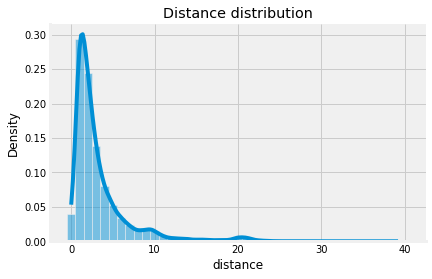

In [26]:
%matplotlib inline
plot_dist(series=data[data.distance < 50].distance, title='Distance distribution')

<div style="font-weight:700">Let's have a look at <i style="color:royalblue">passenger_count</i> feature</div>

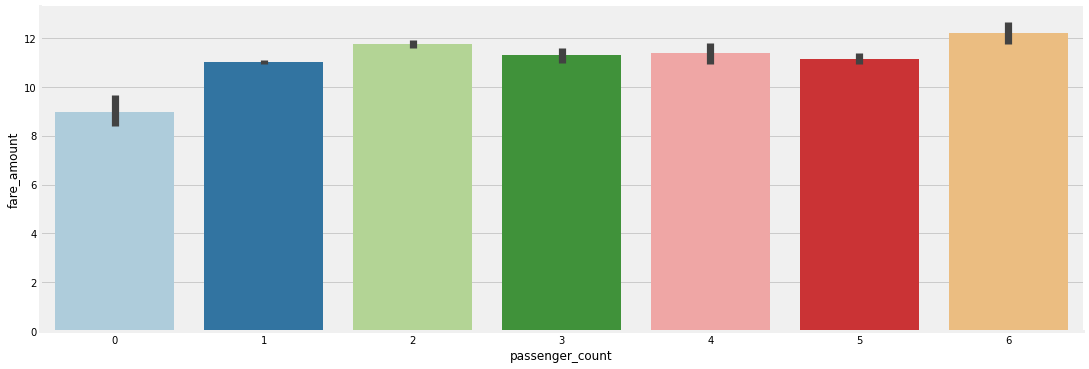

In [27]:
sns.catplot(x="passenger_count", y="fare_amount", palette=palette, data=data, kind="bar", aspect=3)
sns.despine()
plt.show()

<div style="font-weight:700">Let's have a look at <i style="color:royalblue">fare_amount</i> feature by hour</div>

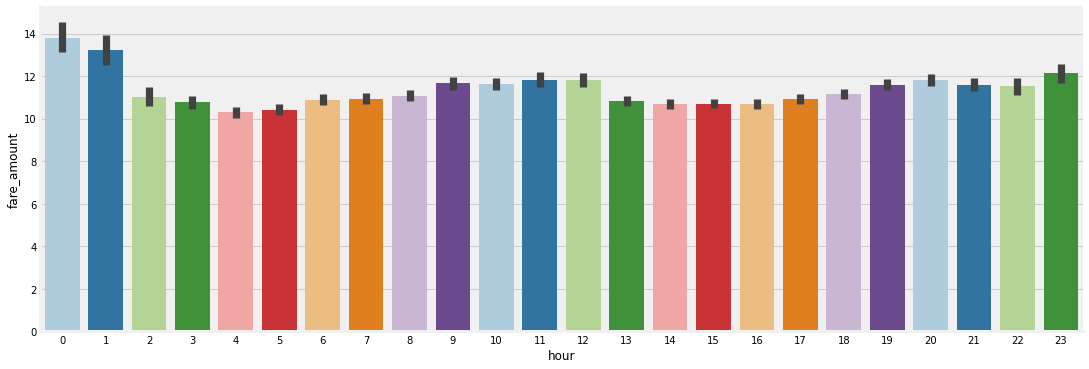

In [28]:
sns.catplot(x="hour", y="fare_amount", palette=palette, data=data, kind="bar", aspect=3)
sns.despine()
plt.show()

<div style="font-weight:700">Let's have a look at <i style="color:royalblue">fare_amount</i> feature by day of week</div>

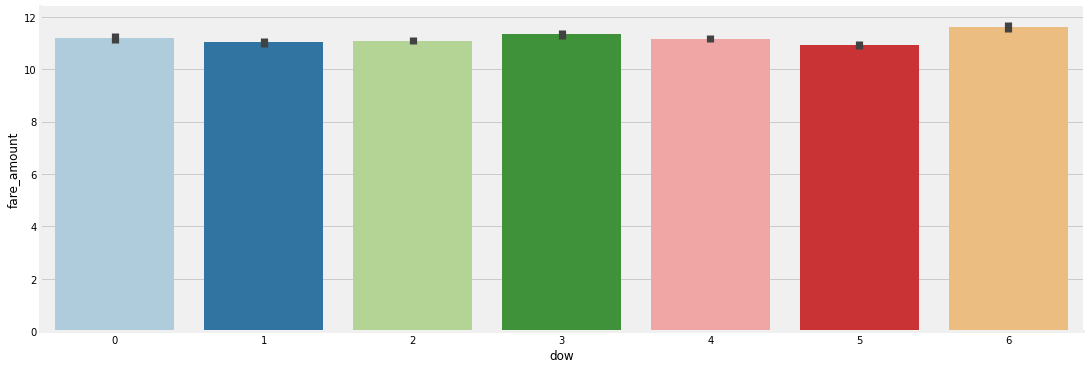

In [29]:
sns.catplot(x="dow", y="fare_amount", palette=palette, data=data, kind="bar", aspect=3)
sns.despine()
plt.show()

<div style="font-weight:700">Let's have a look at the corelation between <i style="color:royalblue">fare_amount</i> and <i style="color:royalblue">distance</i> features</div>

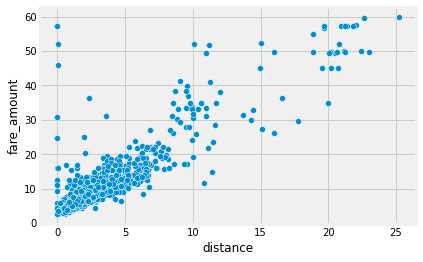

In [31]:
sns.scatterplot(x="distance", y="fare_amount", data=data[data.distance < 80].sample(1000))
plt.show()

In [32]:
data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dow,hour,month,year,count,distance
2,0.00,2010-03-18 19:13:39 UTC,-73.942346,40.806269,-73.942463,40.806129,1,3,15,3,2010,1,0.018420
3,0.01,2015-05-01 15:38:41 UTC,-73.939041,40.713963,-73.941673,40.713997,1,4,11,5,2015,1,0.221878
4,0.01,2015-02-19 06:18:50 UTC,-73.980331,40.770535,-73.981911,40.771503,1,3,1,2,2015,1,0.171158
5,2.50,2013-12-06 05:31:48 UTC,-73.967482,40.756144,-73.967986,40.755634,1,4,0,12,2013,1,0.070839
8,2.50,2015-01-22 21:27:57 UTC,-73.947289,40.779663,-73.946640,40.780491,1,3,16,1,2015,1,0.107023


# 6. Training
<div style="font-weight:700">Starting on a fresh dataset to prepare for training</div>

In [33]:
data_train = pd.read_csv(url, nrows=1000)

## 6.1. Cleaning dataset

In [34]:
def clean_data(df, test=False, predict=False):
    df = df.drop(["key"], axis=1)
    df = df.dropna(how='any', axis='rows')
    df = df[(df.dropoff_latitude != 0) | (df.dropoff_longitude != 0)]
    df = df[(df.pickup_latitude != 0) | (df.pickup_longitude != 0)]
    if "fare_amount" in list(df):
        df = df[df.fare_amount.between(0, 4000)]
    df = df[df.passenger_count < 8]
    df = df[df.passenger_count >= 0]
    df = df[df["pickup_latitude"].between(left=40, right=42)]
    df = df[df["pickup_longitude"].between(left=-74.3, right=-72.9)]
    df = df[df["dropoff_latitude"].between(left=40, right=42)]
    df = df[df["dropoff_longitude"].between(left=-74, right=-72.9)]
    return df
data_train = clean_data(data_train)
data_train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


## 6.2. Preparing model inputs

In [35]:
X_train = data_train.drop(["fare_amount"], axis=1)
y_train = data_train["fare_amount"]

## 6.3. Pipelines

### 6.3.1. Time features

#### 6.3.1.1 Class for time features encoding

In [36]:
class TimeFeaturesEncoder(BaseEstimator, TransformerMixin):
    """Extract the day of week (dow), the hour, the month and the year from a time column."""

    def __init__(self, time_column, time_zone_name='America/New_York'):
        self.time_column = time_column
        self.time_zone_name = time_zone_name

    def extract_time_features(self, X):
        timezone_name = self.time_zone_name
        time_column = self.time_column
        df = X.copy()
        df.index = pd.to_datetime(df[time_column])
        df.index = df.index.tz_convert(timezone_name)
        df["dow"] = df.index.weekday
        df["hour"] = df.index.hour
        df["month"] = df.index.month
        df["year"] = df.index.year        
        return df
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        """Returns a copy of the DataFrame X with only four columns: 'dow', 'hour', 'month', 'year'"""
        return self.extract_time_features(X)[['dow', 'hour', 'month', 'year']].reset_index(drop=True)

#### 6.3.1.2. Test of the TimeFeaturesEncoder

In [37]:
# test the TimeFeaturesEncoder
time_enc = TimeFeaturesEncoder('pickup_datetime')
time_features = time_enc.fit_transform(X_train, y_train)
time_features.head()

,dow,hour,month,year
0,0,13,6,2009
1,1,11,1,2010
2,2,20,8,2011
3,5,0,4,2012
4,1,2,3,2010


#### 6.3.1.3. Pipeline for time features

In [38]:
# TIME PIPELINE
pipe_time = Pipeline([
    ('time_features_create', TimeFeaturesEncoder('pickup_datetime')),
    ('time_features_ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
])
pipe_time

Pipeline(steps=[('time_features_create',
                 TimeFeaturesEncoder(time_column='pickup_datetime')),
                ('time_features_ohe',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

### 6.3.2. Distances

#### 6.3.2.1 Class for distance encoding

In [39]:
def haversine_vectorized(df, 
         start_lat="pickup_latitude",
         start_lon="pickup_longitude",
         end_lat="dropoff_latitude",
         end_lon="dropoff_longitude"):

    """ 
        Calculate the great circle distance between two points 
        on the earth (specified in decimal degrees).
        Vectorized version of the haversine distance for pandas df
        Computes distance in kms
    """

    lat_1_rad, lon_1_rad = np.radians(df[start_lat].astype(float)), np.radians(df[start_lon].astype(float))
    lat_2_rad, lon_2_rad = np.radians(df[end_lat].astype(float)), np.radians(df[end_lon].astype(float))
    dlon = lon_2_rad - lon_1_rad
    dlat = lat_2_rad - lat_1_rad

    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat_1_rad) * np.cos(lat_2_rad) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371 * c

In [40]:
class DistanceTransformer(BaseEstimator, TransformerMixin):
    """Compute the haversine distance between two GPS points."""

    def __init__(self, 
                 start_lat="pickup_latitude",
                 start_lon="pickup_longitude", 
                 end_lat="dropoff_latitude", 
                 end_lon="dropoff_longitude"):
        self.start_lat = start_lat
        self.start_lon = start_lon
        self.end_lat = end_lat
        self.end_lon = end_lon

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        """Returns a copy of the DataFrame X with only one column: 'distance'"""
        return pd.DataFrame(haversine_vectorized(X)).rename(columns={0: "course distance [km]"}).copy()

#### 6.3.2.2. Test of the DistanceTransformer

In [41]:
dist_trans = DistanceTransformer()
distance = dist_trans.fit_transform(X_train, y_train)
distance.head()

,course distance [km]
0,1.030764
1,8.450134
2,1.389525
3,2.799270
4,1.999157


### 6.3.3. Combination of distance and time features pipeline

In [42]:
preprocessor = ColumnTransformer([
    ('distance', DistanceTransformer(), ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']),
    ('time', pipe_time, ['pickup_datetime'])
], remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('distance', DistanceTransformer(),
                                 ['pickup_longitude', 'pickup_latitude',
                                  'dropoff_longitude', 'dropoff_latitude']),
                                ('time',
                                 Pipeline(steps=[('time_features_create',
                                                  TimeFeaturesEncoder(time_column='pickup_datetime')),
                                                 ('time_features_ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['pickup_datetime'])])

### 6.3.4. Full preprocessor pipeline

In [43]:
pipe_prepro = Pipeline([
    ('dist_and_time', preprocessor),
    ('scaler', MinMaxScaler())
])
pipe_prepro

Pipeline(steps=[('dist_and_time',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('distance',
                                                  DistanceTransformer(),
                                                  ['pickup_longitude',
                                                   'pickup_latitude',
                                                   'dropoff_longitude',
                                                   'dropoff_latitude']),
                                                 ('time',
                                                  Pipeline(steps=[('time_features_create',
                                                                   TimeFeaturesEncoder(time_column='pickup_datetime')),
                                                                  ('time_features_ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['pickup_datetime'])])),
                ('scaler', MinMaxScaler())])

### 6.3.5. Finally, Full pipeline. We choose RandomForestRegressor

In [44]:
final_pipe = Pipeline([
    ('preprocessor', pipe_prepro),
    ('model', RandomForestRegressor())
])
final_pipe

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('dist_and_time',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('distance',
                                                                   DistanceTransformer(),
                                                                   ['pickup_longitude',
                                                                    'pickup_latitude',
                                                                    'dropoff_longitude',
                                                                    'dropoff_latitude']),
                                                                  ('time',
                                                                   Pipeline(steps=[('time_features_create',
                                                                                    TimeFeaturesEncoder(time_column='pickup_datetime')),
                                                                                   ('time_features_ohe',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse=False))]),
                                                                   ['pickup_datetime'])])),
                                 ('scaler', MinMaxScaler())])),
                ('model', RandomForestRegressor())])

## 6.4. Definition of custom score for RMSE

In [45]:
def custom_rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_true - y_pred)))

In [46]:
rmse = make_scorer(custom_rmse, greater_is_better=False)

## 6.5. Baseline RMSE for RandomForestRegressor

In [47]:
baseline = cross_validate(final_pipe,
                          X_train,
                          y_train,
                          scoring=rmse,
                          cv=5)
baseline_rmse = -round(baseline["test_score"].mean(), 3)
baseline_rmse

4.661

## 6.6. RandomizedSearchCV for an optimized model

In [48]:
grid_RFR = {'model__n_estimators': stats.randint(1, 300),
            'model__max_depth': stats.randint(1, 300),
            'model__max_samples': stats.randint(1, 300),
            "preprocessor__scaler": [StandardScaler(), RobustScaler(), MinMaxScaler()]
            }

search_RFR = RandomizedSearchCV(final_pipe,
                                grid_RFR,
                                scoring=rmse,
                                n_iter=100,
                                cv=5,
                                n_jobs=-1,
                                verbose=True)
search_RFR.fit(X_train, y_train);

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [49]:
search_RFR.best_params_

{'model__max_depth': 227,
 'model__max_samples': 222,
 'model__n_estimators': 122,
 'preprocessor__scaler': RobustScaler()}

In [50]:
print("Tuned RandomForestRegressor model rmse: " + str(-round(search_RFR.best_score_, 2)))

Tuned RandomForestRegressor model rmse: 4.51
